In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
    
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.layers import Input, Flatten, Dense, Dropout, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
csv_file = 'GermanCreditRisk.csv'

dataframe = pd.read_csv(csv_file)
# Replace NaN with most common value
dataframe = dataframe.fillna(dataframe.mode().iloc[0])

In [4]:
dataframe['target'] = np.where(dataframe['Risk']=="bad", 1, 0)

dataframe.head()

# Oversample the minority class
num_samples = dataframe['target'].value_counts().max()
df_majority = dataframe[dataframe.target == 0]
df_minority = dataframe[dataframe.target == 1]
df_minority_upsampled = df_minority.sample(num_samples, replace=True)
dataframe = pd.concat([df_majority, df_minority_upsampled])

# Create new column called CD which is Credit Amount / Duration
dataframe['CD'] = dataframe['CreditAmount'] / dataframe['Duration']

# Drop unused columns
# Remove gender to avoid bias
dataframe = dataframe.drop(columns=['col', 'Risk', 'Sex'])

dataframe.describe()

,Age,Job,CreditAmount,Duration,target,CD
count,1400.000000,1400.00000,1400.000000,1400.000000,1400.000000,1400.000000
mean,34.999286,1.91000,3412.824286,22.196429,0.500000,165.838595
std,11.179701,0.65087,3018.111410,12.879742,0.500179,177.053219
min,19.000000,0.00000,250.000000,4.000000,0.000000,24.055556
25%,26.000000,2.00000,1337.000000,12.000000,0.000000,82.777778
50%,32.000000,2.00000,2321.500000,18.000000,0.500000,127.229167
75%,41.000000,2.00000,4249.000000,27.000000,1.000000,197.333333
max,75.000000,3.00000,18424.000000,72.000000,1.000000,2482.666667


In [5]:
train, val = train_test_split(dataframe, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')

1120 train examples
280 validation examples


In [6]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))

Every feature: ['Age', 'Job', 'Housing', 'SavingAccounts', 'CheckingAccount', 'CreditAmount', 'Duration', 'Purpose', 'CD']


In [7]:
# Define the feature columns
feature_columns = []

age = tf.feature_column.numeric_column("Age")
# age_buckets should represent students, young adults, middle aged, and seniors
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 30, 50, 65])
print(age_buckets)
feature_columns.append(age_buckets)

# job is a number, but we want to treat it as a categorical feature
job = tf.feature_column.numeric_column("Job")
job = tf.feature_column.bucketized_column(job, boundaries=[1, 2, 3])
job = tf.feature_column.indicator_column(job)
feature_columns.append(job)

housing = tf.feature_column.categorical_column_with_vocabulary_list(
"Housing", ["own", "rent", "free"])
housing = tf.feature_column.indicator_column(housing)
feature_columns.append(housing)

saving_accounts = tf.feature_column.categorical_column_with_vocabulary_list(
"SavingAccounts", ["little", "moderate", "quite rich", "rich", "NA"])
saving_accounts = tf.feature_column.indicator_column(saving_accounts)
feature_columns.append(saving_accounts)

checking_account = tf.feature_column.categorical_column_with_vocabulary_list(
"CheckingAccount", ["little", "moderate", "rich", "NA"])
checking_account = tf.feature_column.indicator_column(checking_account)
feature_columns.append(checking_account)

credit_amount = tf.feature_column.numeric_column("CreditAmount")
feature_columns.append(credit_amount)

# duration is a number, but we want to treat it as a categorical feature, buckets should be 12, 24, 36, 48, 60, 72
duration = tf.feature_column.numeric_column("Duration")
duration = tf.feature_column.bucketized_column(duration, boundaries=[12, 24, 36, 48, 60, 72])
duration = tf.feature_column.indicator_column(duration)
feature_columns.append(duration)

cd = tf.feature_column.numeric_column("CD")
feature_columns.append(cd)

purpose = tf.feature_column.categorical_column_with_vocabulary_list(
"Purpose", ["radio/TV", "education", "furniture/equipment", "car", "business", "domestic appliances", "repairs", "vacation/others"])
purpose = tf.feature_column.indicator_column(purpose)
feature_columns.append(purpose)

# Verify the feature columns
for feature in feature_columns:
  print(feature)
  print("\n")

BucketizedColumn(source_column=NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 30, 50, 65))
BucketizedColumn(source_column=NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 30, 50, 65))


IndicatorColumn(categorical_column=BucketizedColumn(source_column=NumericColumn(key='Job', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1, 2, 3)))


IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Housing', vocabulary_list=('own', 'rent', 'free'), dtype=tf.string, default_value=-1, num_oov_buckets=0))


IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='SavingAccounts', vocabulary_list=('little', 'moderate', 'quite rich', 'rich', 'NA'), dtype=tf.string, default_value=-1, num_oov_buckets=0))


IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='CheckingAccount', vocabulary_list

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns),
    # This is CSV data
    # Convolutions expect 3D data, so we need to reshape the data
    tf.keras.layers.Reshape(target_shape=(38, 1, 1)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(2,2), strides=(1,1), padding='same', activation='LeakyReLU'),
    tf.keras.layers.Dense(16, activation="LeakyReLU"),
    tf.keras.layers.Dense(8, activation='LeakyReLU'),
    tf.keras.layers.Dense(8, activation='LeakyReLU'),
    # Final Dense layer expects 1D data, so we need to flatten the data
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

In [9]:
filepath = r"C:\Users\karan\Programming\Python\Credit-Risk-Classifier\Final Model\weights-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath, save_weights_only=False, save_freq='epoch', verbose=1)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[callback, checkpoint]
)

Epoch 1/50
218/224 [============================>.] - ETA: 0s - loss: 2.1054 - accuracy: 0.5367 - recall: 0.5330WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs={'Age': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=int64>, 'Job': <tf.Tensor 'IteratorGetNext:6' shape=(None,) dtype=int64>, 'Housing': <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=string>, 'SavingAccounts': <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=string>, 'CheckingAccount': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'CreditAmount': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=int64>, 'Duration': <tf.Tensor 'IteratorGetNext:4' shape=(None,) dtype=int64>, 'Purpose': <tf.Tensor 'IteratorGetNext:7' shape=(None,) dtype=string>, 'CD': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=float64>}. Consider rewriting this model with the Functional API.

Epoch 1: saving model to C:\Users\karan\Programming\Python\Credit-Risk-Classifier

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall'])


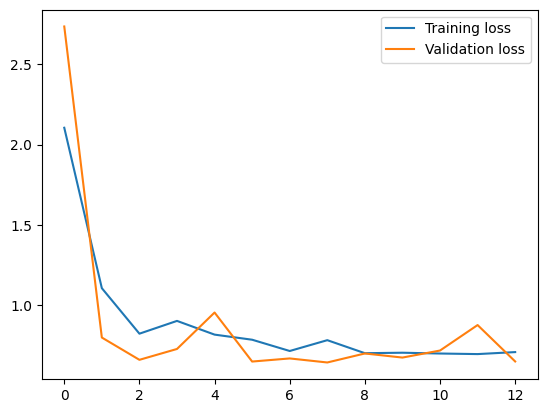

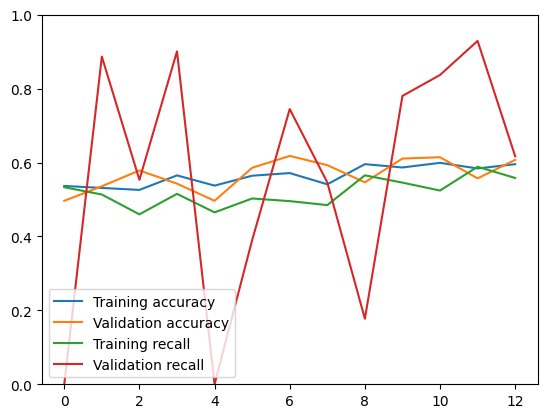

Best validation accuracy: 61.79% at epoch 7
Best validation recall: 92.91% at epoch 12
Best F1 score: 74.22% at epoch 7
1/1 [==============================] - 0s 23ms/step
280
[[83 56]
 [54 87]]


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print(history.history.keys())

recall = history.history['recall']
val_recall = history.history['val_recall']

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# Show accuracy vs recall
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.plot(recall, label='Training recall')
plt.plot(val_recall, label='Validation recall')

plt.ylim([0, 1])
plt.legend()
plt.show()

print("Best validation accuracy: {:.2f}% at epoch {}".format(max(history.history["val_accuracy"])*100, history.history["val_accuracy"].index(max(history.history["val_accuracy"])) + 1))
print("Best validation recall: {:.2f}% at epoch {}".format(max(val_recall)*100, val_recall.index(max(val_recall)) + 1))
print("Best F1 score: {:.2f}% at epoch {}".format(2 * max(history.history["val_accuracy"]) * max(val_recall) / (max(history.history["val_accuracy"]) + max(val_recall)) * 100, history.history["val_accuracy"].index(max(history.history["val_accuracy"])) + 1))

# Create a confusion matrix
predictions = []
actual = []
for feature_batch, label_batch in val_ds:
    predictions.extend(model.predict(feature_batch))
    actual.extend(label_batch.numpy())

predictions = [1 if x > 0.5 else 0 for x in predictions]
actual = [1 if x > 0.5 else 0 for x in actual]

print(len(predictions))

cm = confusion_matrix(actual, predictions)
print(cm)